In [1]:
 from google.colab import drive
 drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cd '/content/drive/My Drive/Colab Notebooks/dl/data' 

/content/drive/.shortcut-targets-by-id/1ZyNJXaTInYA2YPBLOAFnql__PhYO31aJ/data


In [2]:
import os
import numpy as np
import pandas as pd
from tabulate import tabulate
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix


def drop_crr(df,tol=0.8):
	crr = df.corr().abs()
	keep_columns = df.columns.to_list()
	keep_dict = {clm:True for clm in keep_columns}
	for i in range(0,len(keep_columns)-1):
		# Loop over all columns to the right of the current one
	    	for j in range(i+1,len(keep_columns)):
	    		# If the absolute correlation between the current two columns is greater than or equal to 0.8...
	    		if crr[keep_columns[i]].loc[keep_columns[j]] >= tol:
	    			# If we haven't already told the keep_columns list to drop column j...
	    			if keep_dict[keep_columns[j]] == True:
	    				# Drop column j
	    				keep_dict[keep_columns[j]] = False
	selected_columns = [clm for clm in keep_dict if keep_dict[clm] == True]
	df_out = df[selected_columns].copy()
	return df_out, selected_columns

def backwardElimination(x, y, sl, columns):
	numVars = len(x[0])
	for i in range(0, numVars):
		regressor_OLS = sm.OLS(y, x).fit()
		#maxVar = max(regressor_OLS.pvalues).astype(float)
		maxVar = max(regressor_OLS.pvalues)
		if maxVar > sl:
			for j in range(0, numVars - i):
				if (regressor_OLS.pvalues[j].astype(float) == maxVar):
					x = np.delete(x, j, 1)
					columns = np.delete(columns, j)
	regressor_OLS.summary()
	return x, columns
    	
def drop_high_impurity(df, cut_off = 0.01):
	keep_columns = df.columns.to_list()
	keep_dict = {}
	keep_dict = {clm:True for clm in keep_columns}
	for i in range(0,len(keep_columns)-1):
		# Loop over all columns to the right of the current one
		for j in range(i+1,len(keep_columns)):
			# If the importance of the feature calculated based on impurity is greater than or equal to 0.01
			if importances[indices[i]] <= cut_off:
				# If we haven't already told the keep_columns list to drop column j...
				if keep_dict[keep_columns[j]] == True:
					# Drop column j
					keep_dict[keep_columns[j]] = False
	selected_columns = [clm for clm in keep_dict if keep_dict[clm] == True]
	df_out = df[selected_columns].copy()
	return df_out
	
def eval_performance_roc_auc(model, y_test, prediction, cv=5):
	cm = confusion_matrix(y_test, prediction)
	acc = np.trace(cm)/len(y_test)
	roc_auc_scores = cross_val_score(model, x_test, y_test, scoring='roc_auc',cv=5)
	f1_scores_linear = cross_val_score(model, x_test, y_test, scoring='f1',cv=5)
	return cm, acc, mean(roc_auc_scores), mean(f1_scores)

In [6]:
df_base = pd.read_pickle("./hub_spot_export_clean01212021.pkl")

In [10]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336955 entries, 0 to 336954
Data columns (total 34 columns):
 #   Column                                                                      Non-Null Count   Dtype         
---  ------                                                                      --------------   -----         
 0   Contact ID                                                                  336955 non-null  int64         
 1   Became a Lead Date                                                          89826 non-null   datetime64[ns]
 2   Became a Subscriber Date                                                    230453 non-null  datetime64[ns]
 3   First Conversion Date                                                       89822 non-null   datetime64[ns]
 4   First marketing email click date                                            140535 non-null  datetime64[ns]
 5   First marketing email open date                                             297928 non-null  

## (1) Framing the problem, underlying assumptions and selecting a performance measure
### Jason, Sohini, I unsuccesfulty tried to prove the following hypothesis. Underlying assumption (i) can't be proved with the existing data. We need to know exactly what is the business logic that triggers a 'First Conversion' event and consequently its associated timestamp 'First Conversion Date'. It's illogical to try to predict events from an event based on features/events that happened after a "First Conversion Date" was registered.
### Molly Larking gave us the following information a couple of weeks ago:
### We need to define or obtain a definition of "conversion" (e.g. is it a course purchase, event registration, marketing email click?) In case of purchase, what is the URL of a website purchase confirmation? Is course registration the only revenue source? Any paid advertisement, sponsored events, etc that are also considered "conversions"?
### ANSWER Generally it's a purchase, but the only indicator we have is the field "Which of the following courses have you taken...", which isn't a perfect indicator. You can certainly explore other conversion events - I think attending an Event would be another one to explore.
### Only 13,184 out of 89,822 Contact IDs that have a 'First Conversion Date' reported to have taken DL.ai courses. The difference (76,638) can not be explained by subscription or event attendance decisions based on the provided dataset.
### Hypothesis 1: Contact ID Conversion history data distribution from 11/1/2019 until 10/30/2020 is representative enough to allow us to use 'First Conversion Date' information as a Target variable for Binary Classification (If a Contact ID has a 'First Conversion Date' then Target 'Conversion' = 1, otherwise 'Conversion'=0). That same information is also meaningful to be used as a feature (month and day of the month) eventually capturing any conversion seasonality across the 12-month period of time.
### Underlying assumptions:
### (i) A Contact ID conversion is defined by an individual who subscribed to a newsletter or event (voluntarily provided email address, courses taken, level of completed education and etc., becoming a known Contact ID from that moment onwards.
### (ii) All other timestamped events such as first/last marketing emails (sent/opened/clicked), event registration/attendance and email opt-out decisions as POSTERIOR to a conversion event therefore CAN NOT be considered a cause for a conversion decision.
### (iii) Same as (ii) applies to Number of Pageviews and Number of Sessions
### (iv) Deeplearning.ai has not been using sales opportunities and sales leads to engage with potential learners. Data exported from Hub Spot CRM revealed empty "Opportunity" dates and duplicate "Lead" dates (exactly the same as 'First Conversion Date')
### (v) As a consequence of (i) 'Became a Subscriber Date' is redundant with 'First Conversion Date'

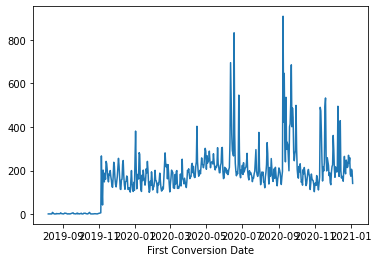

In [12]:
conv_hist = df_base.groupby(df_base['First Conversion Date'].dt.date, dropna=True)['Contact ID'].count()
conv_hist.plot(kind='line')

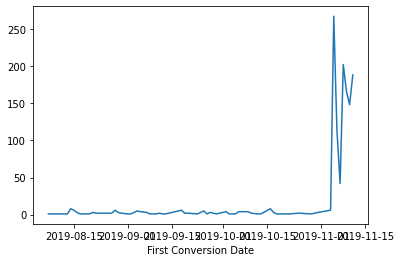

In [25]:
conv_hist[0:60].plot(kind='line')

In [34]:
conv_hist[52]

6

In [35]:
conv_hist[53]

267

In [36]:
conv_hist[conv_hist==267]

First Conversion Date
2019-11-05    267
2020-04-28    267
2020-06-16    267
Name: Contact ID, dtype: int64

In [40]:
# format='%Y-%m-%d %H:%M:%S'
train_start_dt = datetime(year=2019, month=11, day=1, hour=0, minute=0, second=0)
train_end_dt = datetime(year=2020, month=10, day=30, hour=23, minute=59, second=59)

In [52]:
mask = (df_base['First Conversion Date'] >= train_start_dt) & (df_base['First Conversion Date'] <= train_end_dt)

In [ ]:
df_train = df_base.loc[mask]

In [82]:
mask_convs_equals_subs = (df_base['First Conversion Date'] == df_base['Became a Subscriber Date'] )

In [84]:
print(df_base.loc[mask_convs_equals_subs].shape[0],'Contact IDs were converted at the same moment they became subscribers')

137 Contact IDs were converted at the same moment they became subscribers


In [85]:
mask_convs_before_subs = (df_base['First Conversion Date'] < df_base['Became a Subscriber Date'] )

In [87]:
print(df_base.loc[mask_convs_before_subs].shape[0],'Contact IDs were converted before becoming subscribers')

25 Contact IDs were converted before becoming subscribers


In [88]:
mask_convs_after_subs = (df_base['First Conversion Date'] > df_base['Became a Subscriber Date'] )

In [89]:
print(df_base.loc[mask_convs_after_subs].shape[0],'Contact IDs were converted after becoming subscribers')

11221 Contact IDs were converted after becoming subscribers


In [69]:
mask_first_mktg = (df_base['First marketing email send date'] < df_base['Became a Subscriber Date'] )

In [78]:
print(df_base.loc[mask_first_mktg].shape[0],'Contact IDs were converted after receiving a first marketing email')

954 Contact IDs were converted after receiving a first marketing email


In [72]:
mask_last_mktg = (df_base['Last marketing email send date'] < df_base['Became a Subscriber Date'] )

In [79]:
print(df_base.loc[mask_last_mktg].shape[0],'Contact IDs were converted after receiving the last marketing email')

177 Contact IDs were converted after receiving the last marketing email


In [74]:
mask_lead = (df_base['Became a Lead Date'] < df_base['Became a Subscriber Date'] )

In [75]:
print(df_base.loc[mask_lead].shape[0],'Contact IDs were converted after becoming a sales lead')

0 Contact IDs were converted after becoming a sales lead


In [76]:
mask_lead = (df_base['Last Registered Event Date'] < df_base['Became a Subscriber Date'] )

In [77]:
print(df_base.loc[mask_lead].shape[0],'Contact IDs were converted after registering for the last event')

5087 Contact IDs were converted after registering for the last event


In [67]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336955 entries, 0 to 336954
Data columns (total 34 columns):
 #   Column                                                                      Non-Null Count   Dtype         
---  ------                                                                      --------------   -----         
 0   Contact ID                                                                  336955 non-null  int64         
 1   Became a Lead Date                                                          89826 non-null   datetime64[ns]
 2   Became a Subscriber Date                                                    230453 non-null  datetime64[ns]
 3   First Conversion Date                                                       89822 non-null   datetime64[ns]
 4   First marketing email click date                                            140535 non-null  datetime64[ns]
 5   First marketing email open date                                             297928 non-null  

In [ ]:
# df_train = df_base[df_base['First Conversion Date'] >= train_start_dt and df_base['First Conversion Date'] <= train_end_dt ]]

In [37]:
# numeric_columns = df_base.select_dtypes([np.int64, np.float64]).columns.to_list()